In [1]:
import numpy as np 
import pandas as pd
from numba import njit
import matplotlib.pyplot as plt
from math import isnan

from qrm_core.engine import simulate_QRM_jit
from qrm_core.sampling import sample_stationary_lob
from qrm_core.intensity import IntensityTable
from notebook_utils import to_dataframe

from pathlib import Path
ROOT = Path.cwd()
if (ROOT / "calibration_data").exists() is False and (ROOT.parent / "calibration_data").exists():
    ROOT = ROOT.parent
CALIB_DIR = ROOT / "calibration_data"
intensity_path = CALIB_DIR / "intensity_table.npy"
invariant_path = CALIB_DIR / "invariant_distribution.npy"

# QRM Simulations

Run the QRM simulation either 

1) up to a given time horizon with `time_end` (in seconds)

2) up to a maximum number of events in the LOB with `max_nb_events` (default to nan)

In [18]:
# Simulation parameters
time_end = int(1e4)
max_nb_events = np.nan
tick = 0.01 # tick size
theta = 0.7
theta_reinit = 0.85
t0 = 0. # initial time
p_mid = 100.005 # initial mid price
p_ref = 100.005 # initial reference price
aes = [836, 1068, 1069] # avg. nb of shares per LOB event per depth (taken from the QRM paper, K=3)


# Random seed
seed = 2025
np.random.seed(seed)
@njit
def _init_numba(seed): np.random.seed(seed)
_init_numba(seed)

# Build intensity table
inten_arr = np.load(intensity_path)
K, Q1, *_ = inten_arr.shape
inten_table = IntensityTable(max_depth=K, max_queue=Q1-1)
inten_table._data = inten_arr
rate_int_all = np.transpose(inten_table._data, (2,0,1,3)).copy()

# Load invariant distribution
inv_bid = np.load(invariant_path)
inv_ask = np.load(invariant_path) # possibility of bid-ask asymmetry
state = np.empty(2*K, np.int8)

# Initial LOB state: sample from the invariant distribution
state[:K] = sample_stationary_lob(inv_bid, np.empty((0,), np.int8))
state[K:] = sample_stationary_lob(inv_ask, np.empty((0,), np.int8))

if isnan(max_nb_events):
    # stop at time horizon
    max_events_intra = 12 * int(time_end) # numpy length pre-allocation
    # 12 is a large upper bound on the number of events per second
    # might be too small for different calibrated intensities (in which case the code will throw an error)
else:
    # stop after maximum nb of events
    max_events_intra = max_nb_events

times, p_mids, p_refs, sides, depths, events, redrawns, states = simulate_QRM_jit(t0,
                                                                                    p_mid,
                                                                                    p_ref,
                                                                                    state,
                                                                                    rate_int_all,
                                                                                    tick,
                                                                                    theta,
                                                                                    theta_reinit,
                                                                                    time_end,
                                                                                    inv_bid,
                                                                                    inv_ask, 
                                                                                    max_events_intra, 
                                                                                    aes, 
                                                                                    max_nb_events=max_nb_events
                                                                                    )

times = times.astype(np.float64, copy=False)
df = to_dataframe(times, p_mids, p_refs, sides, depths, events, redrawns, states, K)
row_0 = [t0, p_mid, p_ref, -1, -1, -1, False] + state[:K].tolist()[::-1] + state[K:].tolist()
df = pd.concat([pd.DataFrame([row_0], columns=df.columns), df], ignore_index=True)
df

,time,p_mid,p_ref,side,depth,event,redrawn,q_bid3,q_bid2,q_bid1,q_ask1,q_ask2,q_ask3
0,0.000000,100.005,100.005,-1,-1,-1,False,33,23,0,3,11,13
1,0.006905,99.995,99.995,ask,1,cancel,True,14,28,14,4,7,4
2,0.132398,99.995,99.995,bid,2,cancel,False,14,27,14,4,7,4
3,0.293874,99.995,99.995,bid,1,limit,False,14,27,15,4,7,4
4,0.333176,99.995,99.995,ask,2,limit,False,14,27,15,4,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65060,9999.613681,99.825,99.825,ask,3,cancel,False,11,20,11,10,26,13
65061,9999.647800,99.825,99.825,ask,2,limit,False,11,20,11,10,27,13
65062,9999.756290,99.825,99.825,bid,1,cancel,False,11,20,10,10,27,13
65063,9999.922194,99.825,99.825,ask,1,cancel,False,11,20,10,9,27,13


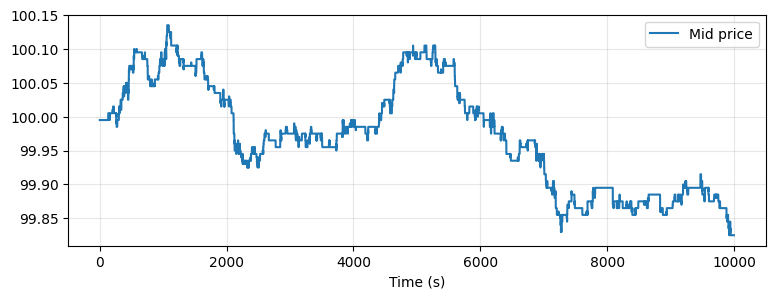

In [17]:
plt.figure(figsize=(9,3))
plt.plot(df['time'], df['p_mid'], label='Mid price')
plt.grid(alpha=0.3)
plt.legend()
plt.xlabel('Time (s)');